# llc4320 drifters spectra: Lagrangian vs Eulerian


**Mask coast areas !!**


In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd

from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr
import mitequinox.plot as pl

# Zoe's color code
ce = 'lightseagreen'
cl = 'firebrick'

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
if False:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=3)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53335,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:49398,Total threads: 7
Dashboard: http://127.0.0.1:37519/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:47658,


---
## load data: variance & spectra

In [4]:
# Eulerian spectra and energy
dsE = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_nomean_lat_lon.zarr'))
dsE = dsE.rename(E_SSUV="E_Eulerian")

/dev/shm/pbs.5721152.datarmor0/ipykernel_41498/1848501958.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  dsE = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_nomean_lat_lon.zarr'))


In [8]:
def load_Eulerian_ke():

    ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/variance.zarr'))
    grd = ut.load_grd(["XC", "YC", "Depth"])
    ds = xr.merge([ds, grd]).reset_coords()

    # bug requires:
    ds = ds.chunk(dict(i=1000, j=1000))
    # https://github.com/xgcm/xhistogram/issues/16

    #SSUV = (ds.SSU.rename(i_g="i") + ds.SSV.rename(j_g="j"))
    #SSUV = SSUV.where(SSUV<10).fillna(1.)
    ds["SSU"] = ds.SSU.rename(i_g="i")
    ds["SSV"] = ds.SSV.rename(j_g="j")
    
    # mask coastal areas:
    ds = ds.where(ds.Depth>500)
    
    # bin average variance
    lon_bins = np.arange(-180,180,1.)
    lat_bins = np.arange(-60,60,1.)
    V = histogram(ds.XC, ds.YC, bins=[lon_bins, lat_bins], 
                  weights=ds.SSU + ds.SSV, 
                 )
    N = histogram(ds.XC, ds.YC, bins=[lon_bins, lat_bins])
    V = V/N
    V = V.rename(XC_bin="lon_bins", YC_bin="lat_bins")
    V = V.rename("kinetic_energy").compute()
    
    return V


In [9]:
KE = load_Eulerian_ke()

/dev/shm/pbs.5721152.datarmor0/ipykernel_41498/2110623137.py:3: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/variance.zarr'))
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [10]:
# Lagrangian spectra
run_name = 'global_extra_T365j_dt1j_dij50_XCYC'
p = pa.parcels_output(os.path.join(ut.root_data_dir, "parcels/"+run_name))
dsL = p.load_diagnostic('spectra_uv_T60_mean1_lat_lon.zarr')
# mean0: raw
# mean1: demeaned
# mean2: mean velocity field
dsL = dsL.rename(E="E_Lagrangian")

/home1/datahome/aponte/mit_equinox/mitequinox/parcels.py:1656: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  data = xr.open_zarr(data_path, **kwargs)


In [11]:
# merge
ds = xr.merge([KE, dsE, dsL]).unify_chunks()

---
## start conditionning by energy level

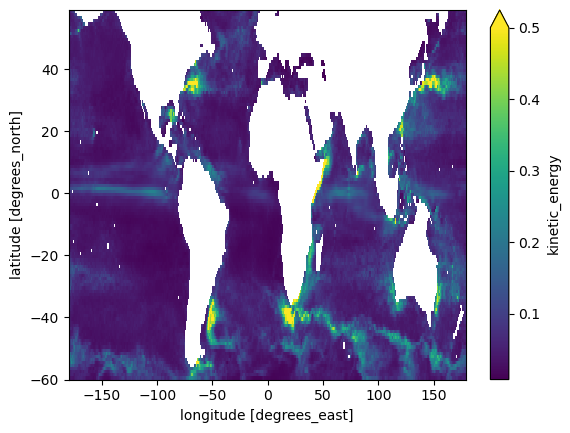

In [36]:
KE.plot(x="lon_bins", y="lat_bins", vmax=0.5)

(array([   6., 1207., 3076., 4899., 4321., 3428., 2633., 1915., 1486.,
        1200.,  868.,  792.,  615.,  565.,  478.,  374.,  296.,  276.,
         233.,  207.,  158.,  110.,  121.,  109.,   78.,   74.,   61.,
          59.,   62.,   40.,   46.,   60.,   45.,   33.,   22.,   27.,
          23.,   19.,   13.,   13.,   21.,   20.,   19.,    6.,   12.,
          18.,    9.,   10.,    8.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49]),
 <BarContainer object of 49 artists>)

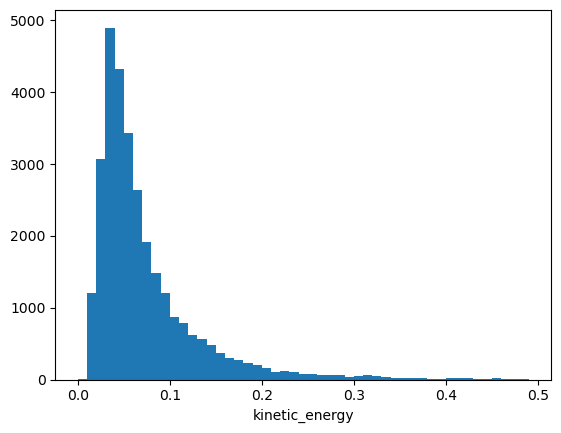

In [12]:
fig, ax = plt.subplots(1,1)
KE.plot.hist(bins=np.arange(0, .5, .01), ax=ax)
#ax.set_yscale("log")

In [89]:
ke_bins = np.arange(0,.5,.06)

def get_E_conditionned(e, ds):
    
    ke = ds.kinetic_energy.fillna(-1.)
    
    E = histogram(ke, bins=ke_bins, dim=["lon_bins", "lat_bins"], weights=ds[e].fillna(0.))
    N = histogram(ke, bins=ke_bins, dim=["lon_bins", "lat_bins"])

    E = E/N
    E = (E
         .rename(kinetic_energy_bin="ke")
         .assign_coords(frequency=ds.frequency)
         .compute()
    )
    
    return E

dsb = xr.merge([get_E_conditionned(e, ds).rename(e) for e in ["E_Eulerian", "E_Lagrangian"]])

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/dask/array/core.py:1711: FutureWarning: The `numpy.histogram_bin_edges` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/dask/array/core.py:1711: FutureWarning: The `numpy.histogram_bin_edges` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [90]:
xlim = [1.5, 2.5]

def plot_spectra(xlim=None, figsize=None, rescale=False):

    offsets = np.arange(0, dsb.ke.size)*4
    colors = pl.get_cmap_colors(dsb.ke.size, cmap="inferno")

    fig, ax = plt.subplots(1,1, figsize=None)

    for ke, off, c in zip(dsb.ke, offsets, colors):
        _ds = dsb.sel(ke=ke)
        if xlim is not None and rescale:
            E_max = float(_ds.E_Eulerian.where( (_ds.frequency>xlim[0]) & (_ds.frequency<xlim[1]) ).max())
        else:
            E_max = 1.
        #E_max = 1.
        if rescale:
            E_rescale = off/E_max
        else:
            E_rescale = 1.
        #E_rescale = 1/E_max
        (_ds.E_Eulerian*E_rescale).plot(x="frequency", color=c, ax=ax, label=f"ke={float(ke):.2f}")
        (_ds.E_Lagrangian*E_rescale).plot(x="frequency", color=c, ls='--', ax=ax)

    ax.set_yscale("log")
    ax.legend()
    ax.grid()
    return ax

def plot_spectra_ratio(figsize=None):

    colors = pl.get_cmap_colors(dsb.ke.size, cmap="inferno")

    fig, ax = plt.subplots(1,1, figsize=figsize)

    for ke, c in zip(dsb.ke, colors):
        _ds = dsb.sel(ke=ke)
        ratio = _ds.E_Eulerian / _ds.E_Lagrangian
        ratio.plot(x="frequency", color=c, ax=ax, label=f"ke={float(ke):.2f}")

    #ax.set_yscale("log")
    ax.set_ylim(0,4)
    ax.legend()
    ax.grid()
    ax.set_title("E_Eulerian / E_Lagrangian")
    
    return ax

(0.0, 5.0)

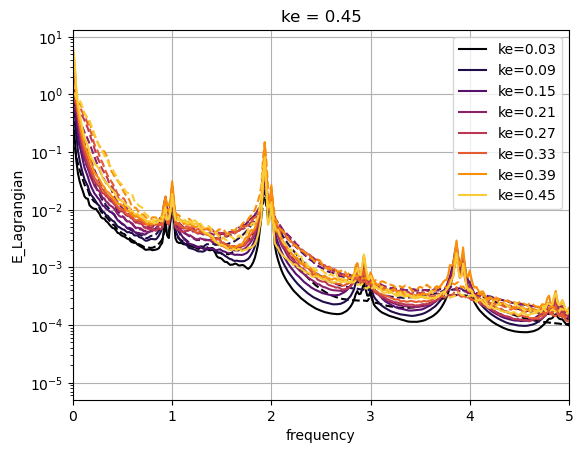

In [91]:
ax = plot_spectra()
ax.set_xlim(0,5)

(0.0, 1.0)

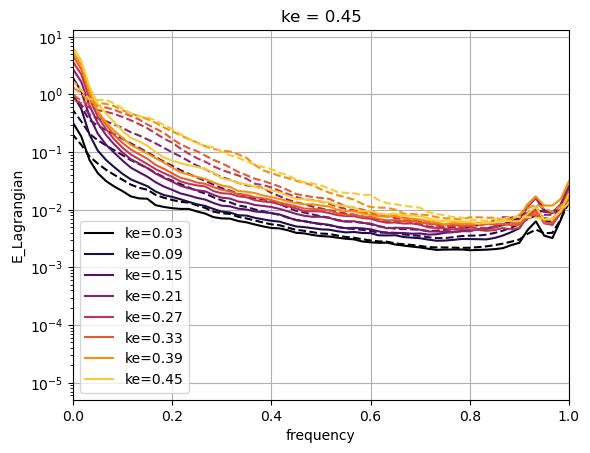

In [92]:
ax = plot_spectra()
ax.set_xlim(0,1)

- High energy Eulerian spectra are moderately steeper than $f^{-2}$ at low frequencies, no evidence of a plateau.
- High energy Lagrangian exhibit a plateau, followed by a steeper than $f^{-2}$ fall off.
- Low energy Eulerian and Lagrangian spectra are closer to $f^{-2}$ at low frequencies.

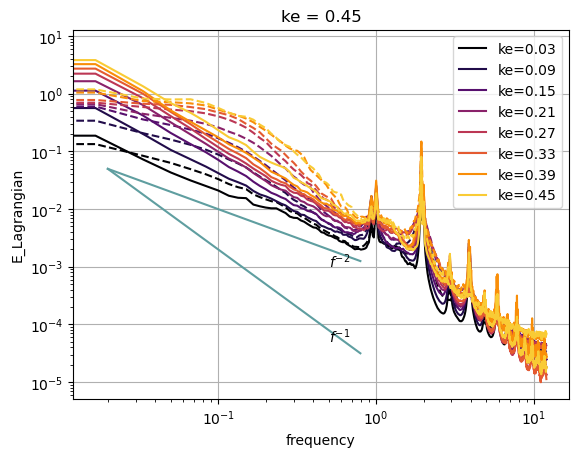

In [93]:
ax = plot_spectra()
#ax.set_xlim(0,5)

freq = 10**np.arange(-1.7,0,.1)
ax.plot(freq, 5e-2*(freq[0]/freq)**2, color="cadetblue")
ax.text(5e-1, 1e-3, r"$f^{-2}$")
ax.plot(freq, 5e-2*(freq[0]/freq)**1, color="cadetblue")
ax.text(5e-1, 5e-5, r"$f^{-1}$")
ax.set_xscale("log")

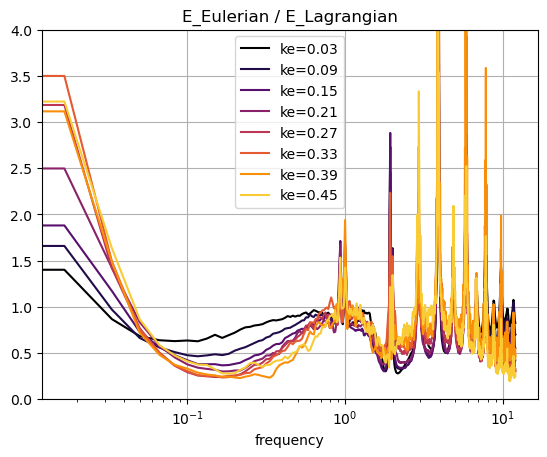

In [94]:
ax = plot_spectra_ratio()
#ax.set_xlim(0,5)
ax.set_xscale("log")

(0.0, 5.0)

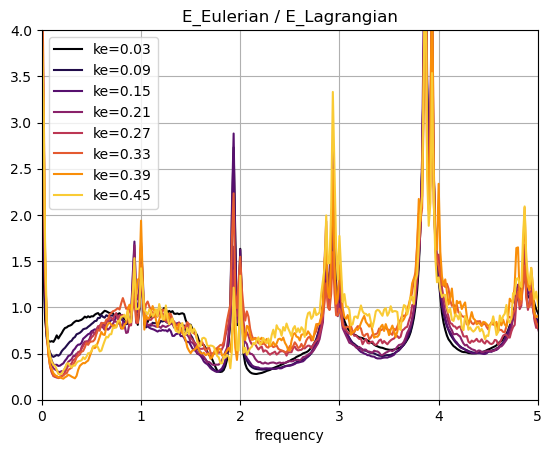

In [95]:
ax = plot_spectra_ratio()
ax.set_xlim(0,5)

(0.0001, 0.5)

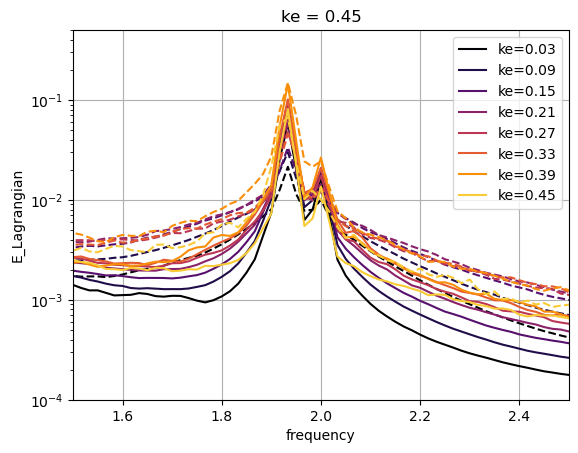

In [96]:
ax = plot_spectra(figsize=(7,10))
ax.set_xlim([1.5, 2.5])
ax.set_ylim(1e-4, 5e-1)

(0.0, 5.0)

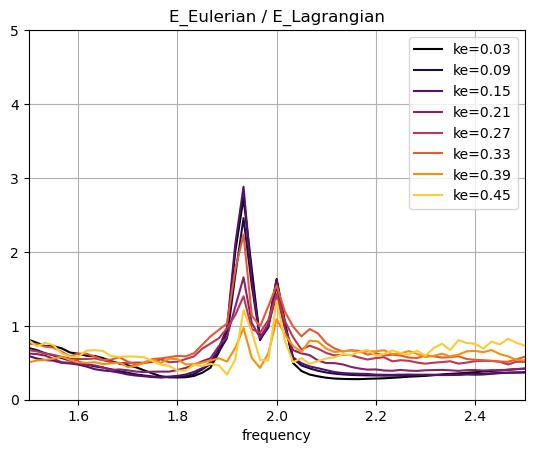

In [97]:
#figsize=(7,10)
ax = plot_spectra_ratio()
ax.set_xlim([1.5, 2.5])
ax.set_ylim(0,5)

In [98]:
ds2 = dsb.where( (dsb.frequency>1.8) & (dsb.frequency<2.2) ).sum("frequency")
df = float(dsb["frequency"].diff("frequency")[1])

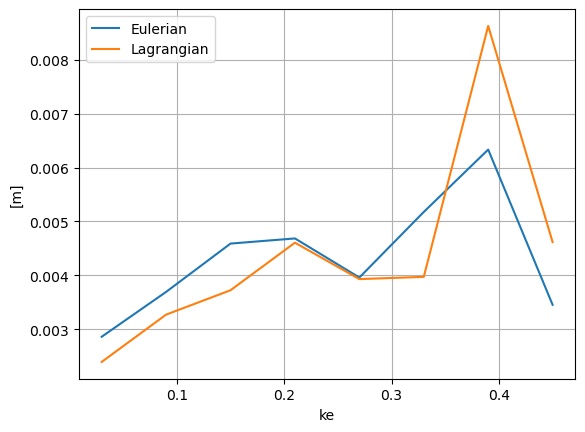

In [99]:
fig, ax = plt.subplots(1,1)
(ds2.E_Eulerian*df).plot(label="Eulerian")
(ds2.E_Lagrangian*df).plot(label="Lagrangian")
ax.set_title("")
ax.set_ylabel("[m]")
ax.grid()
ax.legend()

### show masks

In [100]:
ke_bins, len(ke_bins)

(array([0.  , 0.06, 0.12, 0.18, 0.24, 0.3 , 0.36, 0.42, 0.48]), 9)

Text(0.5, 1.0, '0.0<ke<0.06  mask')

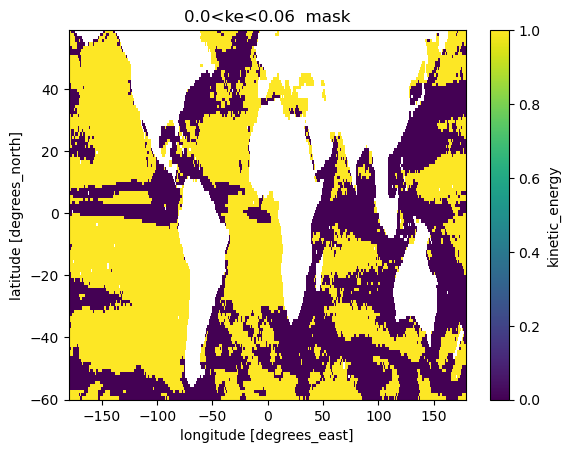

In [101]:
i = 0
mask = ((0*ds.kinetic_energy + 1)
        .where( (ds.kinetic_energy>ke_bins[i]) & (ds.kinetic_energy<ke_bins[i+1]), other=0)
        .where( ds.kinetic_energy>0 )
)

fig, ax = plt.subplots(1,1)
mask.plot(x="lon_bins", y="lat_bins")
ax.set_title(f"{ke_bins[i]}<ke<{ke_bins[i+1]}  mask")

Text(0.5, 1.0, '0.06<ke<0.12  mask')

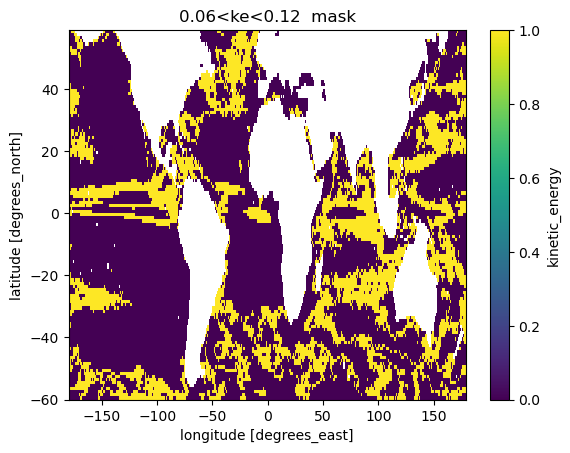

In [109]:
i = 1
mask = ((0*ds.kinetic_energy + 1)
        .where( (ds.kinetic_energy>ke_bins[i]) & (ds.kinetic_energy<ke_bins[i+1]), other=0)
        .where( ds.kinetic_energy>0 )
)

fig, ax = plt.subplots(1,1)
mask.plot(x="lon_bins", y="lat_bins")
ax.set_title(f"{ke_bins[i]}<ke<{ke_bins[i+1]}  mask")